# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp

In [132]:
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv('base/processed.cleveland.data', 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [120]:
def bivariada_qualitativa (
        data:pd.DataFrame,
        resposta:str,
        explicativa:str
        )-> pd.DataFrame:
    """
    Realiza uma análise bivariada entre a variável resposta e a variável explicativa.

    Parâmetros:
        data (pd.DataFrame): DataFrame contendo os dados.
        resposta (str): Nome da variável resposta (coluna do DataFrame).
        explicativa (str): Nome da variável explicativa (coluna do DataFrame).

    Retorna:
        pd.DataFrame: Dataframe com as análises dos dados da bivariada
    """
    #Validação dos tipos das variáveis
    if not isinstance(resposta, str)        : raise TypeError("Os argumento 'resposta' deve ser string.")
    if not isinstance(explicativa, str)     : raise TypeError("Os argumento 'explicativa' deve ser string.")
    if not isinstance(data, pd.DataFrame)   : raise TypeError("Os argumento 'data' deve ser um dataframe.")

    # Verificando se as variáveis existem no DataFrame
    if resposta not in data.columns     :raise ValueError(f"A Variável '{resposta}' não encontrada no Dataframe.")
    if explicativa not in data.columns  :raise ValueError(f"A Variável '{explicativa}' não encontrada no Dataframe.")

    ##Análise
    tab = pd.crosstab(data[resposta],data[explicativa],margins=True)

    tab['probabilidade']    = tab[1]/tab['All']
    tab['chance']           = tab[1]/tab[0]
    tab['RC_vs_All']        = tab['chance']/tab.loc['All','chance']
    tab['logito']           = np.log(tab['chance'])
    tab['WOE']              = np.log(tab['RC_vs_All'])
 
    return tab


In [52]:
df.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0


In [54]:
bivariada_qualitativa(df,'sex','flag_doente')

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [94]:
bivariada_qualitativa(df,'slope','flag_doente')


flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,0.400706,-1.079920,-0.914528
2.0,49,91,140,0.650000,1.857143,2.191161,0.619039,0.784432
3.0,9,12,21,0.571429,1.333333,1.573141,0.287682,0.453075
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [56]:
bivariada_qualitativa(df,'fbs','flag_doente')


flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [119]:
def bivariada_quantitativa (
        data:pd.DataFrame,
        resposta:str,
        explicativa:str,
        quebra:int = 5
        )-> pd.DataFrame:
    """
    Realiza uma análise bivariada entre a variável resposta e a variável explicativa.

    Parâmetros:
        data (pd.DataFrame): DataFrame contendo os dados.
        resposta (str): Nome da variável resposta (coluna do DataFrame).
        explicativa (str): Nome da variável explicativa (coluna do DataFrame).
        quebra (int): numero de categorias, default = 5

    Retorna:
        pd.DataFrame: Dataframe com as análises dos dados da bivariada
    """
    #Validação dos tipos das variáveis
    if not isinstance(data, pd.DataFrame)   :raise TypeError("O argumento 'data' deve ser um dataframe.")
    if not isinstance(resposta, str)        :raise TypeError("O argumento 'resposta' deve ser string.")
    if not isinstance(explicativa, str)     :raise TypeError("O argumento 'explicativa' deve ser string.")
    if not isinstance(quebra, int)          :raise TypeError("O argumento 'quebra' deve ser um inteiro.")

    # Verificando se as variáveis existem no DataFrame
    if resposta not in data.columns     :raise ValueError(f"A Variável '{resposta}' não encontrada no Dataframe.")
    if explicativa not in data.columns  :raise ValueError(f"A Variável '{explicativa}' não encontrada no Dataframe.")

    ##Análise
    data['grupo'] = pd.qcut(data[resposta],q=quebra)
    tab = pd.crosstab(data['grupo'],data[explicativa],margins=True)
    
    tab['probabilidade']    = tab[1]/tab['All']
    tab['chance']           = tab[1]/tab[0]
    tab['RC_vs_All']        = tab['chance']/tab.loc['All','chance']
    tab['logito']           = np.log(tab['chance'])
    tab['WOE']              = np.log(tab['RC_vs_All'])
    tab['média']            = data.groupby('grupo', observed=False)[resposta].mean()

 
    return tab

In [143]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [136]:
bivariada_quantitativa(df.copy(),'age','flag_doente')

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE,média
grupo,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,41.222222
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,50.000000
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,56.211268
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,60.355556
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,66.516667
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,NaN


In [140]:
bivariada_quantitativa(df.copy(),'thalach','flag_doente',10)


flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE,média
grupo,,,,,,,,,
"(70.999, 116.0]",7,25,32,0.781250,3.571429,4.213772,1.272966,1.438358,105.687500
"(116.0, 130.0]",9,22,31,0.709677,2.444444,2.884093,0.893818,1.059210,124.419355
"(130.0, 140.6]",10,18,28,0.642857,1.800000,2.123741,0.587787,0.753179,135.321429
"(140.6, 146.0]",10,21,31,0.677419,2.100000,2.477698,0.741937,0.907330,143.483871
"(146.0, 153.0]",21,11,32,0.343750,0.523810,0.618020,-0.646627,-0.481235,150.187500
"(153.0, 159.0]",18,12,30,0.400000,0.666667,0.786571,-0.405465,-0.240073,156.500000
"(159.0, 163.0]",23,12,35,0.342857,0.521739,0.615577,-0.650588,-0.485195,161.571429
"(163.0, 170.0]",18,9,27,0.333333,0.500000,0.589928,-0.693147,-0.527755,167.481481
"(170.0, 176.6]",21,5,26,0.192308,0.238095,0.280918,-1.435085,-1.269692,172.846154


In [147]:
bivariada_quantitativa(df.copy(),'trestbps','flag_doente',3)

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,logito,WOE,média
grupo,,,,,,,,,
"(93.999, 122.667]",63,38,101,0.376238,0.603175,0.711659,-0.505549,-0.340156,113.801980
"(122.667, 138.0]",57,47,104,0.451923,0.824561,0.972864,-0.192904,-0.027511,130.432692
"(138.0, 200.0]",44,54,98,0.551020,1.227273,1.448005,0.204794,0.370187,151.459184
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,NaN


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [153]:
reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age',data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:                  0.2605
Time:                        10:17:51   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [171]:
df['predito'] = reglog.predict(df)
cat_pred = pd.qcut(df['predito'],q=5,duplicates='drop')
group_reg = df.groupby(cat_pred,observed=True)
qualid = group_reg[['flag_doente']].count()
qualid['predito'] = group_reg['predito'].mean()
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid


,flag_doente,predito,pct_doente
predito,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


Text(0.5, 0, 'Grupo')

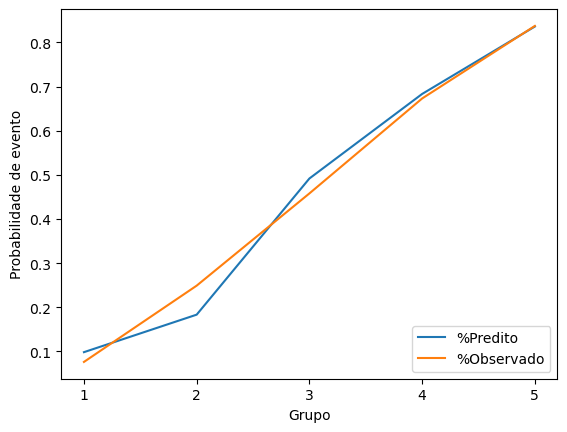

In [172]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doente'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [183]:
acc = metrics.accuracy_score(df['flag_doente'],df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

gini = 2*auc_-1
print('GINI: {0:.2f}%'.format(gini*100))


ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}%'.format(ks*100))



Acurácia: 77.89%
GINI: 66.22%
KS: 58.40%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [198]:
reglog2 = smf.logit('flag_doente ~ sex + oldpeak + exang + age',data=df).fit()
reglog2.summary()

Optimization terminated successfully.
         Current function value: 0.486810
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:                  0.2942
Time:                        10:40:33   Log-Likelihood:                -147.50
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.236e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.2958      1.046     -5.064      0.000      -7.346      -3.246
sex            1.4119      0.332      4.255      0.000       0.761       2.062
oldpeak        0.7099      0.146      4.877      0.000       0.425       0.995
exang          1.7140      0.318      5.392      0.000       1.091       2.337
age            0.0526      0.017      3.074      0.002       0.019       0.086
==============================================================================
"""

In [204]:
df2 = df.copy()
df2['predito'] = reglog2.predict(df2)
cat_pred2 = pd.qcut(df2['predito'],q=5,duplicates='drop')
group_reg2 = df2.groupby(cat_pred2,observed=True)
qualid2 = group_reg2[['flag_doente']].count()
qualid2['predito'] = group_reg2['predito'].mean()
qualid2['pct_doente'] = group_reg2['flag_doente'].mean()
qualid2

,flag_doente,predito,pct_doente
predito,,,
"(0.0329, 0.172]",67,0.105851,0.119403
"(0.172, 0.31]",54,0.229280,0.203704
"(0.31, 0.529]",61,0.397669,0.409836
"(0.529, 0.797]",60,0.675592,0.666667
"(0.797, 0.991]",61,0.897272,0.901639


Text(0.5, 0, 'Grupo')

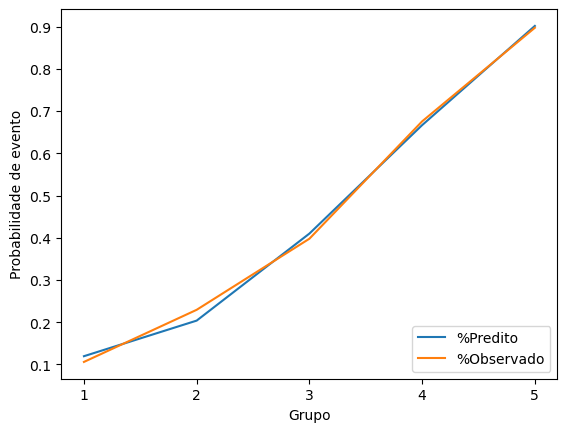

In [205]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid2['pct_doente'].plot(label='%Predito')
ax = qualid2['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

In [203]:
acc = metrics.accuracy_score(df2['flag_doente'],df2['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

fpr, tpr, thresholds = metrics.roc_curve(df2['flag_doente'], df2['predito'])
auc_ = metrics.auc(fpr, tpr)

gini = 2*auc_-1
print('GINI: {0:.2f}%'.format(gini*100))


ks = ks_2samp(df2.loc[df2['flag_doente'] == 1, 'predito'], df2.loc[df2['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}%'.format(ks*100))


Acurácia: 76.57%
GINI: 68.54%
KS: 54.87%
